# RNSA Bone Age

In [142]:
import pandas as pd
import numpy as np

import pickle

from os import listdir, mkdir, rename, makedirs
from os.path import isfile, join, isdir

from sklearn.utils import shuffle

import matplotlib.pyplot as plt
import seaborn as sns

import keras
from keras import layers, models, regularizers, optimizers
from keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications import Xception, InceptionV3
from keras.layers import Flatten, Dense, Dropout, Conv2D
from keras.models import Model, Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [2]:
train = pd.read_csv('../rsna-bone-age/boneage-training-dataset.csv', index_col='id')
test = pd.read_csv('../rsna-bone-age/test.csv', index_col='id')

In [3]:
train.shape, test.shape

((12611, 2), (200, 2))

## Descriptives of dataset

In [4]:
train['gender'] = train.apply(lambda row: 'male' if row['male']==True else 'female', axis=1)
test['gender'] = test.apply(lambda row: 'male' if row['male']==True else 'female', axis=1)

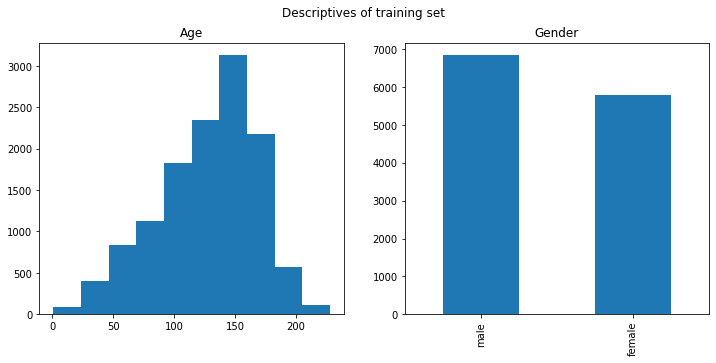

In [5]:
fig = plt.figure(figsize=(12,5)) 
fig_dims = (1, 2)
fig.suptitle('Descriptives of training set')

plt.subplot2grid(fig_dims, (0, 0))
plt.hist(train['boneage'])
plt.title('Age')

plt.subplot2grid(fig_dims, (0, 1))
train['gender'].value_counts().plot(kind='bar', title='Gender');

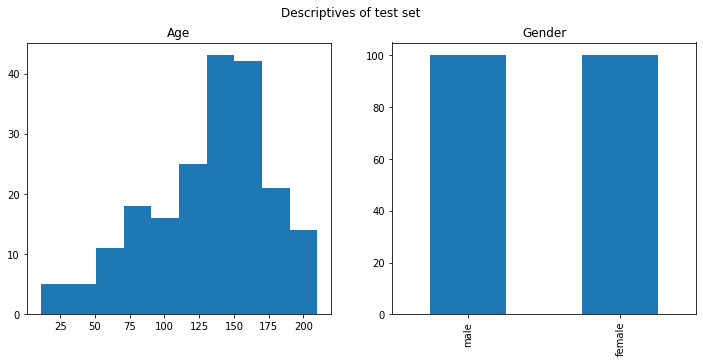

In [6]:
fig = plt.figure(figsize=(12,5)) 
fig_dims = (1, 2)
fig.suptitle('Descriptives of test set')

plt.subplot2grid(fig_dims, (0, 0))
plt.hist(test['boneage'])
plt.title('Age')

plt.subplot2grid(fig_dims, (0, 1))
test['gender'].value_counts().plot(kind='bar', title='Gender');

## Add image path to df

In [7]:
def imgs_path(df, typ):
    """
    Function to add the image path to df
    """
    
    path = '../rsna-bone-age/boneage-{}-dataset/'.format(typ)
    df['img_path'] = None
    for img in listdir(path):
        if img.endswith('.png'):
            img_path = path + img 
            df.loc[(int(img.strip('.png'))), 'img_path'] = img_path
    return df

In [8]:
train = imgs_path(train, 'training')
test = imgs_path(test, 'test')

In [9]:
train.shape, test.shape

((12611, 4), (200, 4))

### Resizing and Padding
Code for the resize and padding function was taken from: https://jdhao.github.io/2017/11/06/resize-image-to-square-with-padding/

In [10]:
import sys
import cv2

def resize_padding_img(img_path, desired_size):
    """
    Function to resize the image with padding
    """
    
    desired_size = desired_size
    im_pth = img_path

    im = cv2.imread(im_pth)
    old_size = im.shape[:2] # old_size is in (height, width) format

    ratio = float(desired_size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])

    # new_size should be in (width, height) format

    im = cv2.resize(im, (new_size[1], new_size[0]))

    delta_w = desired_size - new_size[1]
    delta_h = desired_size - new_size[0]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)

    color = [0, 0, 0]
    new_im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)

    return new_im

def resize_padding_set(df, img_set, desired_size, save):
    """
    Function to resize the entire set of images with padding and save to a desired path
    """
    
    # Create directory for resized and padded images
    dirname = '../rsna-bone-age/resized_padded/{}'.format(img_set)
    if save:
        makedirs(dirname)
    
    # Create extra column in df to save path to resized and padded image
    df['rp_img_path'] = None
    
    for index, row in df.iterrows():
        # Resizing and padding
        img_path = row['img_path']
        if save:
            rp_img = resize_padding_img(img_path, desired_size)
        
        # Write resized and padded images to disk
        filename = '{}.jpg'.format(index)
        if save:    
            cv2.imwrite(dirname + '/' + filename, rp_img) 
        
        # Save path to resized and padded image to df
        df.loc[index, 'rp_img_path'] = filename
        
    return df

In [11]:
train = resize_padding_set(train, 'training', 500, False)
test = resize_padding_set(test, 'test', 500, False)

In [12]:
train.shape, test.shape

((12611, 5), (200, 5))

### Image Data Generator to prevent memory error

In [68]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                  validation_split=0.15)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train, 
    directory='../rsna-bone-age/resized_padded_500/training',
    x_col='rp_img_path',
    y_col='boneage',
    target_size=(275,275),
    color_mode='rgb',
    class_mode='other',
    batch_size=64,
    subset='training')

validation_generator = train_datagen.flow_from_dataframe(
    dataframe=train, 
    directory='../rsna-bone-age/resized_padded_500/training',
    x_col='rp_img_path',
    y_col='boneage',
    target_size=(275,275),
    color_mode='rgb',
    class_mode='other',
    batch_size=64,
    subset='validation')

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test,
    directory='../rsna-bone-age/resized_padded_500/test',
    x_col='rp_img_path',
    y_col='boneage',
    target_size=(275,275),
    color_mode='rgb',
    class_mode='other',
    batch_size=200) # All images from test set in one batch

Found 10720 validated image filenames.
Found 1891 validated image filenames.
Found 200 validated image filenames.


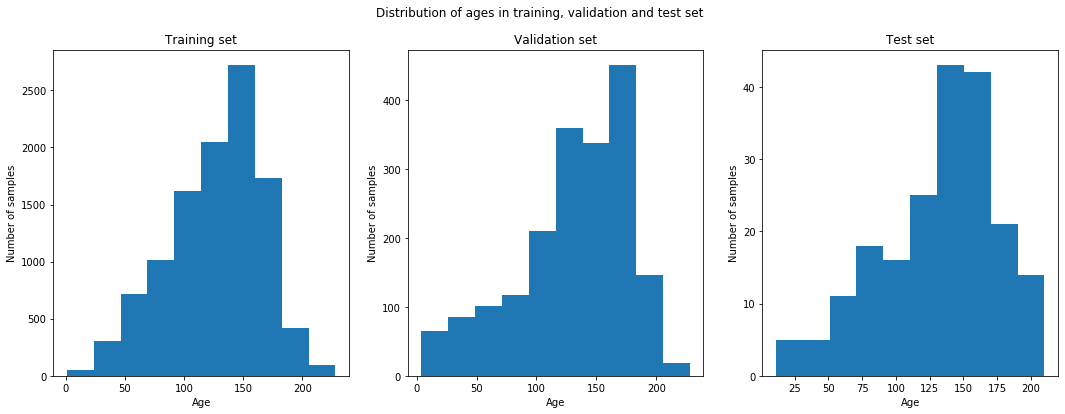

In [177]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,6))
fig.suptitle('Distribution of ages in training, validation and test set')
    
ax1.hist(train_generator.labels)
ax1.set_xlabel('Age')
ax1.set_ylabel('Number of samples')
ax1.set_title('Training set')
    
ax2.hist(validation_generator.labels)
ax2.set_xlabel('Age')
ax2.set_ylabel('Number of samples')
ax2.set_title('Validation set')

ax3.hist(test_generator.labels)
ax3.set_xlabel('Age')
ax3.set_ylabel('Number of samples')
ax3.set_title('Test set');

### Plot a few images in the training set

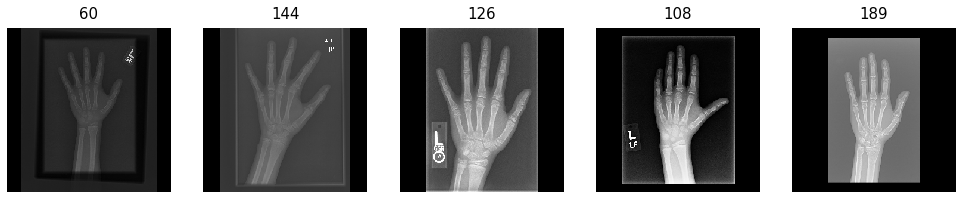

In [111]:
def plot_images(generator):
    X, y = next(generator)
    fig, axes = plt.subplots(1, len(X[15:20]), figsize=(17, 5))
    for idx, ax in enumerate(axes):
        ax.axis('off')
        ax.imshow(X[idx][:,:,::-1])
        ax.set_title(y[idx], size=15, pad=10)

plot_images(train_generator)

In [112]:
X_t, y_t = next(train_generator)

## Deep Learning
### Initial CNN

In [126]:
def build_model(dense_hidden_size=16, dropout_rate=None):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(X_t.shape[1],X_t.shape[2],X_t.shape[3])))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Conv2D(32, kernel_size=(3,3), activation='relu'))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(dense_hidden_size, activation='relu'))
    if dropout_rate:
        model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(1, activation='linear'))
    return model

#### Default model

In [114]:
model=build_model()
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 273, 273, 32)      896       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 136, 136, 32)      0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 134, 134, 32)      9248      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 67, 67, 32)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 143648)            0         
_________________________________________________________________
dense_9 (Dense)              (None, 16)                2298384   
_________________________________________________________________
dense_10 (Dense)             (None, 1)                

In [115]:
model.compile(optimizer='adam',
              loss='mse',
              metrics=['mae'])

# early_stopping = EarlyStopping(monitor='val_mae', patience=10)

# checkpointer = ModelCheckpoint(filepath='../models/keras_weights_{}.hdf5'.format(model.name),
#                                monitor='val_mae',
#                                save_best_only=True)

# callbacks = [early_stopping, checkpointer]

history = model.fit_generator(train_generator,
                              epochs=30,
                              validation_data=validation_generator, 
                              verbose=1)

Epoch 1/30
168/168 [==============================] - 611s 4s/step - loss: 2249.3741 - mae: 36.7238 - val_loss: 3118.7695 - val_mae: 53.0305
Epoch 2/30
168/168 [==============================] - 551s 3s/step - loss: 1361.5004 - mae: 29.6976 - val_loss: 2239.2336 - val_mae: 42.0746
Epoch 3/30
168/168 [==============================] - 547s 3s/step - loss: 1240.1400 - mae: 28.2195 - val_loss: 1897.2964 - val_mae: 37.6780
Epoch 4/30
168/168 [==============================] - 542s 3s/step - loss: 1133.7338 - mae: 26.8468 - val_loss: 2190.7395 - val_mae: 36.6334
Epoch 5/30
168/168 [==============================] - 544s 3s/step - loss: 1047.1887 - mae: 25.7003 - val_loss: 3239.4453 - val_mae: 39.0053
Epoch 6/30
168/168 [==============================] - 548s 3s/step - loss: 992.9274 - mae: 24.9657 - val_loss: 1306.6100 - val_mae: 37.0188
Epoch 7/30
168/168 [==============================] - 550s 3s/step - loss: 870.0359 - mae: 23.2655 - val_loss: 1367.2535 - val_mae: 34.6696
Epoch 8/30
168/

In [122]:
def plot_history(history):    
    mae = history['mae']
    val_mae = history['val_mae']
    loss = history['loss']
    val_loss = history['val_loss']
    epochs = range(1, len(mae)+1)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,4))
    fig.suptitle('Training and Validation MAE and Loss')
    
    ax1.plot(epochs, mae)
    ax1.plot(epochs, val_mae)
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('MAE')
    ax1.set_title('MAE')
    ax1.legend(['training', 'validation'])
    
    ax2.plot(epochs, loss)
    ax2.plot(epochs, val_loss)
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.set_title('Loss')
    ax2.legend(['training', 'validation'])

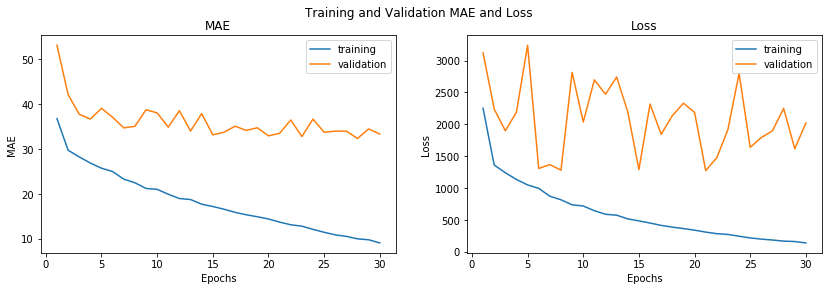

In [123]:
plot_history(history.history)

In [120]:
# save results to dictionary
results = {}
results['model_default'] = {'params': {'dense_hidden_size': 16,
                                     'dropout': None},
                            'history': history.history}

We can see that the model is overfitting, as validation mae is a lot higher than training mae. Furthermore, training mae decreases over the epochs, but validation mae stagnates/increases. In order to avoid overfitting, I am going to instantiate a model with dropout.

#### Model with regularization: dropout

In [127]:
model_dropout = build_model(dropout_rate=0.5)
model_dropout.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 273, 273, 32)      896       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 136, 136, 32)      0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 134, 134, 32)      9248      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 67, 67, 32)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 143648)            0         
_________________________________________________________________
dense_11 (Dense)             (None, 16)                2298384   
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)               

In [128]:
model_dropout.compile(optimizer='adam',
                      loss='mse',
                      metrics=['mae'])

history_dropout = model_dropout.fit_generator(train_generator,
                                              epochs=30,
                                              validation_data=validation_generator,
                                              verbose=1)

Epoch 1/30
168/168 [==============================] - 661s 4s/step - loss: 3719.8862 - mae: 48.6861 - val_loss: 3662.7539 - val_mae: 54.0504
Epoch 2/30
168/168 [==============================] - 670s 4s/step - loss: 3106.0030 - mae: 44.9531 - val_loss: 4037.5508 - val_mae: 59.7339
Epoch 3/30
168/168 [==============================] - 663s 4s/step - loss: 2907.2940 - mae: 43.3852 - val_loss: 2946.5630 - val_mae: 45.2882
Epoch 4/30
168/168 [==============================] - 698s 4s/step - loss: 2864.1660 - mae: 42.9357 - val_loss: 1598.5208 - val_mae: 39.2987
Epoch 5/30
168/168 [==============================] - 637s 4s/step - loss: 2765.9436 - mae: 42.0852 - val_loss: 3162.1418 - val_mae: 42.1275
Epoch 6/30
168/168 [==============================] - 623s 4s/step - loss: 2701.9736 - mae: 41.6269 - val_loss: 2979.9773 - val_mae: 48.6547
Epoch 7/30
168/168 [==============================] - 735s 4s/step - loss: 2729.1875 - mae: 41.7522 - val_loss: 2525.8650 - val_mae: 44.0015
Epoch 8/30
16

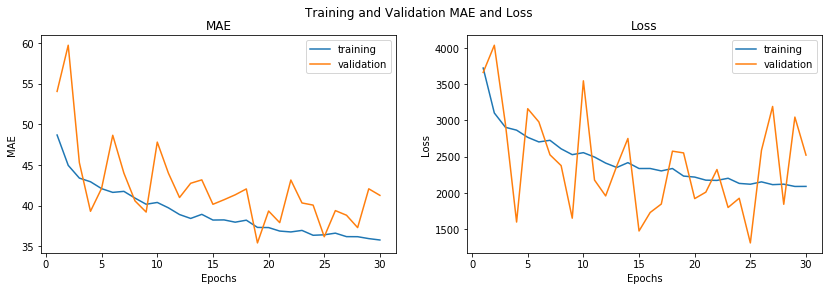

In [129]:
plot_history(history_dropout.history)

In [130]:
# Add to results dictionary
results['model_dropout50'] = {'params': {'dense_hidden_size': 16,
                                         'dropout': 0.50},
                              'history': history_dropout.history}

Seems like a dropout rate of 0.50 is too high, I will now try a dropout rate of 0.20.

In [131]:
model_dropout20 = build_model(dropout_rate=0.2)
model_dropout20.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 273, 273, 32)      896       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 136, 136, 32)      0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 134, 134, 32)      9248      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 67, 67, 32)        0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 143648)            0         
_________________________________________________________________
dense_13 (Dense)             (None, 16)                2298384   
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)               

In [132]:
model_dropout20.compile(optimizer='adam',
                        loss='mse',
                        metrics=['mae'])

history_dropout20 = model_dropout20.fit_generator(train_generator,
                                                  epochs=30,
                                                  validation_data=validation_generator,
                                                  verbose=1)

Epoch 1/30
168/168 [==============================] - 619s 4s/step - loss: 2585.2449 - mae: 40.0091 - val_loss: 3449.7598 - val_mae: 53.0055
Epoch 2/30
168/168 [==============================] - 580s 3s/step - loss: 1898.3471 - mae: 35.0918 - val_loss: 3217.5535 - val_mae: 42.8990
Epoch 3/30
168/168 [==============================] - 578s 3s/step - loss: 1744.3047 - mae: 33.5140 - val_loss: 2400.3271 - val_mae: 49.1554
Epoch 4/30
168/168 [==============================] - 586s 3s/step - loss: 1609.8726 - mae: 32.0058 - val_loss: 2359.5605 - val_mae: 39.5500
Epoch 5/30
168/168 [==============================] - 581s 3s/step - loss: 1548.7054 - mae: 31.4276 - val_loss: 2134.1523 - val_mae: 37.1067
Epoch 6/30
168/168 [==============================] - 579s 3s/step - loss: 1490.0251 - mae: 30.8378 - val_loss: 2916.8809 - val_mae: 43.9044
Epoch 7/30
168/168 [==============================] - 579s 3s/step - loss: 1489.8521 - mae: 30.7882 - val_loss: 2277.9290 - val_mae: 39.9362
Epoch 8/30
16

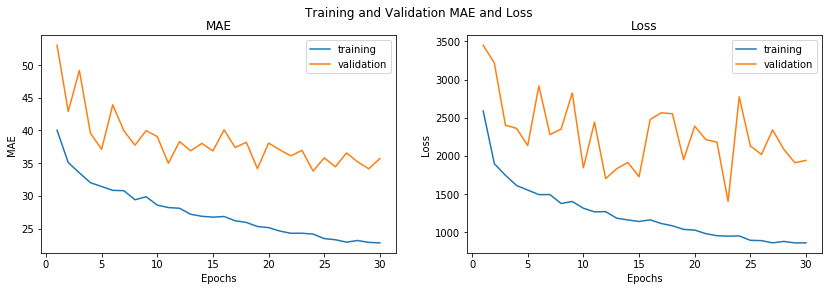

In [133]:
plot_history(history_dropout20.history)

In [143]:
# Save results of model with dropout rate of 0.20 to results dictionary
results['model_dropout20'] = {'params': {'dense_hidden_size': 16,
                                         'dropout': 0.20},
                              'history': history_dropout20.history}

Now, I will try to increase the number of hidden neurons in the dense layer

#### Model with more hidden neurons

In [155]:
model_dense32 = build_model(dense_hidden_size=32)
model_dense32.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_23 (Conv2D)           (None, 273, 273, 32)      896       
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 136, 136, 32)      0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 134, 134, 32)      9248      
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 67, 67, 32)        0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 143648)            0         
_________________________________________________________________
dense_23 (Dense)             (None, 32)                4596768   
_________________________________________________________________
dense_24 (Dense)             (None, 1)               

In [156]:
model_dense32.compile(optimizer='adam',
                      loss='mse',
                      metrics=['mae'])

history_dense32 = model_dense32.fit_generator(train_generator,
                                              epochs=30,
                                              validation_data=validation_generator,
                                              verbose=1)

Epoch 1/30
168/168 [==============================] - 660s 4s/step - loss: 2132.4386 - mae: 35.8325 - val_loss: 3639.1382 - val_mae: 52.1478
Epoch 2/30
168/168 [==============================] - 578s 3s/step - loss: 1341.2874 - mae: 29.5579 - val_loss: 3465.2520 - val_mae: 47.5138
Epoch 3/30
168/168 [==============================] - 577s 3s/step - loss: 1171.2169 - mae: 27.3917 - val_loss: 2709.9377 - val_mae: 36.8306
Epoch 4/30
168/168 [==============================] - 570s 3s/step - loss: 1041.4732 - mae: 25.7048 - val_loss: 1950.0544 - val_mae: 38.1075
Epoch 5/30
168/168 [==============================] - 620s 4s/step - loss: 914.7139 - mae: 23.9750 - val_loss: 1818.3052 - val_mae: 34.8854
Epoch 6/30
168/168 [==============================] - 740s 4s/step - loss: 792.0641 - mae: 22.1699 - val_loss: 2771.1826 - val_mae: 38.6530
Epoch 7/30
168/168 [==============================] - 570s 3s/step - loss: 694.2568 - mae: 20.6813 - val_loss: 1981.6473 - val_mae: 33.4272
Epoch 8/30
168/1

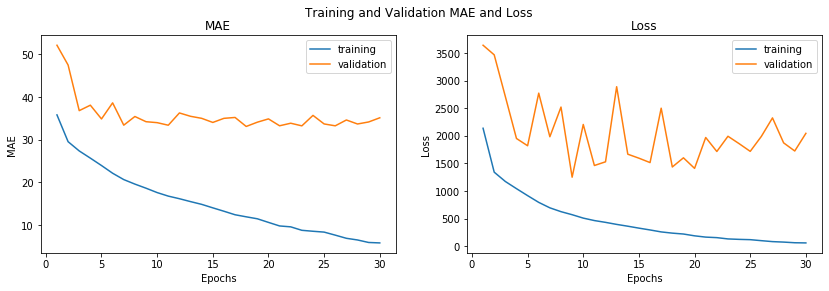

In [158]:
plot_history(history_dense32.history)

In [159]:
# Save results of model with 32 dense hidden neurons
results['model_dense32'] = {'params': {'dense_hidden_size': 32,
                                       'dropout': None},
                            'history': history_dense32.history}

We can see that this model is overfitting. Therefore, I will apply a regularization technique. This time, I will apply dropout with a rate of 0.35.

#### Add regularization: dropout rate 0.35

In [178]:
model_dense32_dropout35 = build_model(dense_hidden_size=32, dropout_rate=0.35)
model_dense32_dropout35.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 273, 273, 32)      896       
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 136, 136, 32)      0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 134, 134, 32)      9248      
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 67, 67, 32)        0         
_________________________________________________________________
flatten_13 (Flatten)         (None, 143648)            0         
_________________________________________________________________
dense_25 (Dense)             (None, 32)                4596768   
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)              

In [179]:
model_dense32_dropout35.compile(optimizer='adam',
                                loss='mse',
                                metrics=['mae'])

history_dense32_dropout35 = model_dense32_dropout35.fit_generator(train_generator,
                                                                  epochs=30,
                                                                  validation_data=validation_generator,
                                                                  verbose=1)

Epoch 1/30
168/168 [==============================] - 612s 4s/step - loss: 2627.6720 - mae: 40.3254 - val_loss: 4207.7939 - val_mae: 53.2833
Epoch 2/30
168/168 [==============================] - 581s 3s/step - loss: 1745.3627 - mae: 33.7002 - val_loss: 2748.1382 - val_mae: 42.8420
Epoch 3/30
168/168 [==============================] - 578s 3s/step - loss: 1591.3171 - mae: 32.1039 - val_loss: 2550.7468 - val_mae: 34.4854
Epoch 4/30
168/168 [==============================] - 572s 3s/step - loss: 1494.5952 - mae: 31.0969 - val_loss: 2794.8213 - val_mae: 43.1112
Epoch 5/30
168/168 [==============================] - 568s 3s/step - loss: 1373.1826 - mae: 29.5414 - val_loss: 1630.8865 - val_mae: 37.6845
Epoch 6/30
168/168 [==============================] - 570s 3s/step - loss: 1324.8525 - mae: 29.1665 - val_loss: 2012.3246 - val_mae: 41.4297
Epoch 7/30
168/168 [==============================] - 565s 3s/step - loss: 1248.6983 - mae: 28.2728 - val_loss: 1582.5863 - val_mae: 37.6640
Epoch 8/30
16

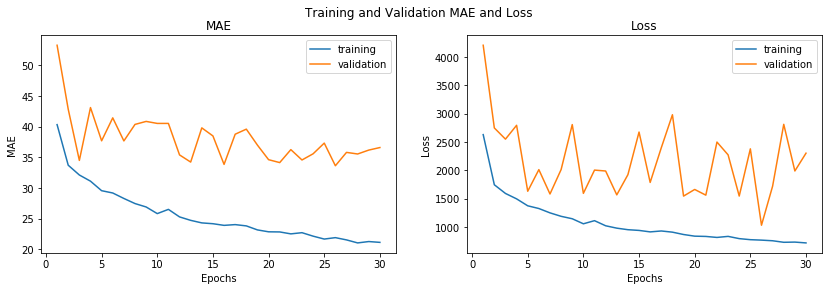

In [180]:
plot_history(history_dense32_dropout35.history)

In [181]:
# Save results of model with 32 dense hidden neurons
results['model_dense32_dropout35'] = {'params': {'dense_hidden_size': 32,
                                                 'dropout': 0.35},
                                      'history': history_dense32_dropout35.history}

Still some overfitting. I will try a higher dropout percentage (0.50) now.

#### Add regularization: dropout rate 0.50

In [186]:
model_dense32_dropout50 = build_model(dense_hidden_size=32, dropout_rate=0.50)
model_dense32_dropout50.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_29 (Conv2D)           (None, 273, 273, 32)      896       
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 136, 136, 32)      0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 134, 134, 32)      9248      
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 67, 67, 32)        0         
_________________________________________________________________
flatten_15 (Flatten)         (None, 143648)            0         
_________________________________________________________________
dense_29 (Dense)             (None, 32)                4596768   
_________________________________________________________________
dropout_5 (Dropout)          (None, 32)              

In [187]:
model_dense32_dropout50.compile(optimizer='adam',
                                loss='mse',
                                metrics=['mae'])

history_dense32_dropout50 = model_dense32_dropout50.fit_generator(train_generator,
                                                                  epochs=30,
                                                                  validation_data=validation_generator,
                                                                  verbose=1)

Epoch 1/30
168/168 [==============================] - 556s 3s/step - loss: 2979.8159 - mae: 43.3482 - val_loss: 3659.3682 - val_mae: 54.2016
Epoch 2/30
168/168 [==============================] - 550s 3s/step - loss: 2351.8222 - mae: 39.0472 - val_loss: 3920.8362 - val_mae: 54.5976
Epoch 3/30
168/168 [==============================] - 550s 3s/step - loss: 2235.5937 - mae: 38.0017 - val_loss: 1771.9471 - val_mae: 41.3419
Epoch 4/30
168/168 [==============================] - 552s 3s/step - loss: 2105.3465 - mae: 36.9648 - val_loss: 2763.4465 - val_mae: 44.9713
Epoch 5/30
168/168 [==============================] - 550s 3s/step - loss: 2006.3333 - mae: 35.8930 - val_loss: 2189.1028 - val_mae: 39.2149
Epoch 6/30
168/168 [==============================] - 552s 3s/step - loss: 1972.9755 - mae: 35.5215 - val_loss: 2214.4495 - val_mae: 40.2597
Epoch 7/30
168/168 [==============================] - 549s 3s/step - loss: 1883.8479 - mae: 34.8330 - val_loss: 3895.8611 - val_mae: 48.5344
Epoch 8/30
16

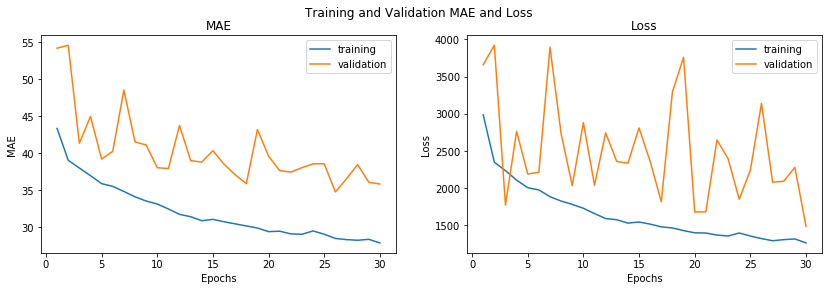

In [190]:
plot_history(history_dense32_dropout50.history)

In [188]:
# Save results of model with 32 dense hidden neurons
results['model_dense32_dropout50'] = {'params': {'dense_hidden_size': 32,
                                                 'dropout': 0.50},
                                      'history': history_dense32_dropout50.history}

In [189]:
# Save results dictionary to pickle file
with open('./results/results.pickle', 'wb') as file:
    pickle.dump(results, file)